<a href="https://colab.research.google.com/github/kacperkurowski/CE888/blob/master/Assignment/Heart-Disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Assignment 2

#Declaring Libraries

In [28]:
pip install scikit-plot

In [0]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from zipfile import ZipFile
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler 
from sklearn.metrics import roc_auc_score
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

#Loading Data

In [30]:
data = "https://raw.githubusercontent.com/kacperkurowski/CE888/master/Assignment/heart.csv"
df_Original_Data = pd.read_csv(data, header=0, sep=',', quotechar='"')
print(df_Original_Data)

     age  sex  cp  trestbps  chol  fbs  ...  exang  oldpeak  slope  ca  thal  target
0     63    1   3       145   233    1  ...      0      2.3      0   0     1       1
1     37    1   2       130   250    0  ...      0      3.5      0   0     2       1
2     41    0   1       130   204    0  ...      0      1.4      2   0     2       1
3     56    1   1       120   236    0  ...      0      0.8      2   0     2       1
4     57    0   0       120   354    0  ...      1      0.6      2   0     2       1
..   ...  ...  ..       ...   ...  ...  ...    ...      ...    ...  ..   ...     ...
298   57    0   0       140   241    0  ...      1      0.2      1   0     3       0
299   45    1   3       110   264    0  ...      0      1.2      1   0     3       0
300   68    1   0       144   193    1  ...      0      3.4      1   2     3       0
301   57    1   0       130   131    0  ...      1      1.2      1   1     3       0
302   57    0   1       130   236    0  ...      0      0.0      

The data used was taken from kaggle and analysed. Its small, and multiple columns can be used to control the amount of covariate shift. I focused on the cholesterol in the blood vs heart disease.

#Creating the test & train datasets from Original dataset

In [0]:
target_var = "target"
cholesterol = 225

df_training = df_Original_Data.where(df_Original_Data["chol"]<=cholesterol).dropna().drop(columns=[target_var])
df_testing = df_Original_Data.where(df_Original_Data["chol"]>cholesterol).dropna().drop(columns=[target_var])


The Data has covariate shift implemented into it, also, using a cholesterol value of 225 seperates the testing and training data into roughtly 30:70 ratio.

#Detecting Covariate shift in data

In [0]:
def classify(MergedData, feature):
  X = MergedData.drop(columns=[feature]) 
  y = MergedData[feature]

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)
  
  rfc = RandomForestClassifier()
  rfc.fit(X_train, y_train)
  y_test_score = rfc.predict_proba(X_test)
  skplt.metrics.plot_roc_curve(y_test, y_test_score)
  plt.show()
  print('AUC score: ', round(roc_auc_score(y_true=y_test, y_score=y_test_score[:,1]), 4))
  return X,y;


The classifier function is above and it detects if covariate shift is present based on the output score. a score of 1.0 means there is certainly covariate shift, a score of approximately 0.8 is when is starts to decrease and become uuncertain.

Test Column is added to differentiate between the test and train data when checking for covariate shift

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


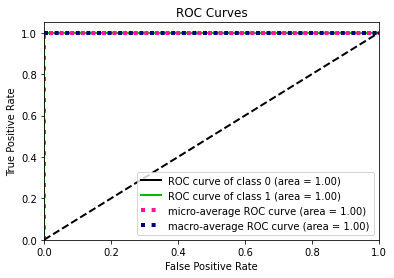

AUC score:  1.0


In [33]:
df_training['test'] = 0
df_testing['test'] = 1
df = pd.concat([df_training, df_testing], axis = 0)
X,y = classify(df,"test")


The Value of 1.0 implies that there is certainly covariate shift present, as the classifier can deduce whether data is from the testing or training data.

#Searching for variables that are causing covariant shift and dropping them

In [34]:
dropped_variables = []
RFCClassifier = RandomForestClassifier(n_estimators = 50, max_depth = 5,min_samples_leaf = 5)
for n in X.columns:
    value = cross_val_score(RFCClassifier,pd.DataFrame(X[n]),y,cv=2,scoring='roc_auc')
    if (np.mean(value) > 0.8):
        dropped_variables.append(n)
        print(n,np.mean(value))


chol 0.9907407407407407
